In [3]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [4]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])


In [5]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [6]:
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)


In [8]:
df_time_series.head()


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.0,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1502.0,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.0,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.0,258.300000,6,0,0


In [9]:
df_channels.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [10]:
video_metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA


# Check length of videos uploaded on YouTube between 2005-05-24 to 2019-11-20

An idea would be to use **cut** to match length of videos into discrete intervals 

In [11]:
video_metadatas.duration.describe()


count    7.292479e+07
mean     7.576761e+02
std      1.820111e+03
min      1.000000e+00
25%      1.340000e+02
50%      2.840000e+02
75%      6.980000e+02
max      3.601570e+05
Name: duration, dtype: float64

In [12]:
# To make it easier, we convert the lengths of videos,to minutes...
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

Text(0.5, 1.0, 'Duration of Videos in Minutes')

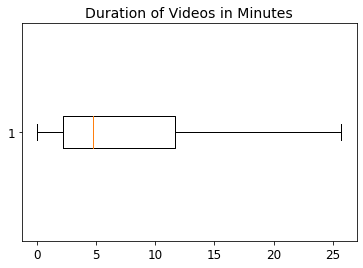

In [14]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")


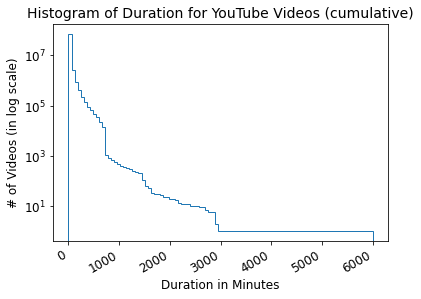

In [15]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


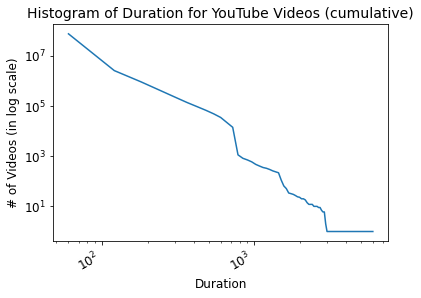

In [16]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


In [13]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos uploaded on YouTube between 2005-05-24 to 2019-11-20

In [17]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


Text(0.5, 1.0, 'Number of videos uploaded each week')

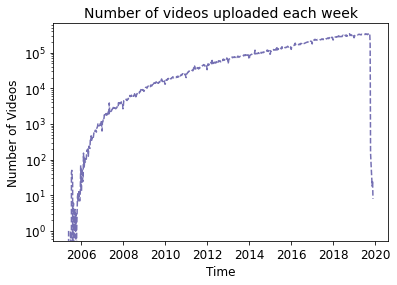

In [18]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos uploaded each week")


In [20]:
# The following graph shows how many videos each channel uploads to YouTube per year.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None


In [22]:
# We remove the channels that uploaded less than 12 videos throughout the study period. JUSTIFY WHY 12 OR DELAY / DELETE

vd_cnt_by_id_yr_filtered = vd_cnt_by_id_yr[vd_cnt_by_id_yr.sum(axis=1) > 12]


In [23]:
vd_cnt_by_id_yr_filtered_summary = vd_cnt_by_id_yr_filtered.describe()


Text(0.5, 1.0, 'The 2nd and 3rd quartiles of yearly video upload frequency')

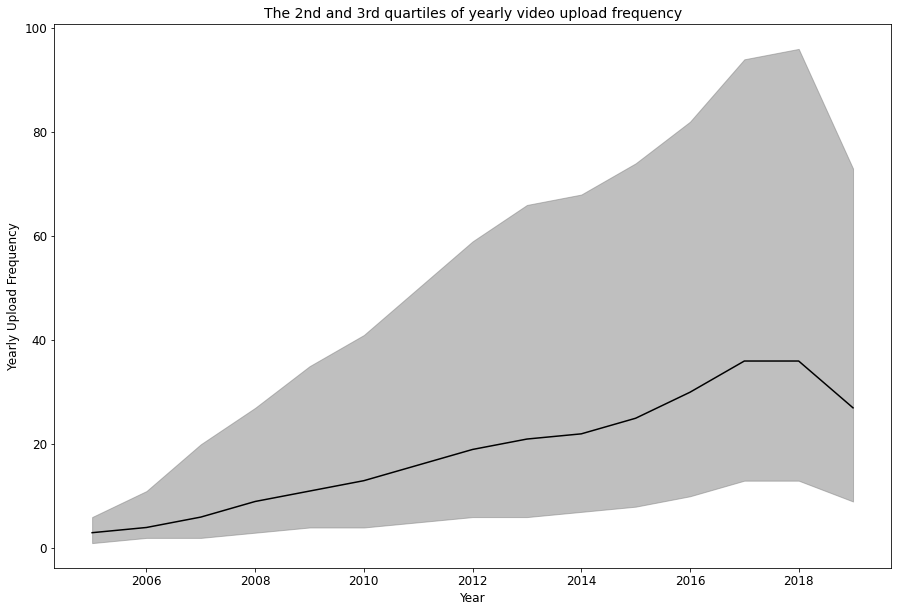

In [36]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_filtered_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_filtered_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_filtered_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_filtered_summary.loc["50%", :], color="black")

plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The 2nd and 3rd quartiles of yearly video upload frequency")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates


# Weekday Analysis

In [25]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None


In [26]:
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)


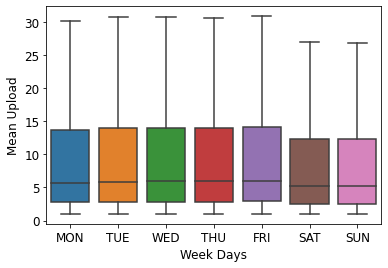

In [32]:
labels = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
).set(
    xlabel='Week Days', 
    ylabel='Mean Upload',
    xticklabels= labels)


In [33]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None


In [34]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)


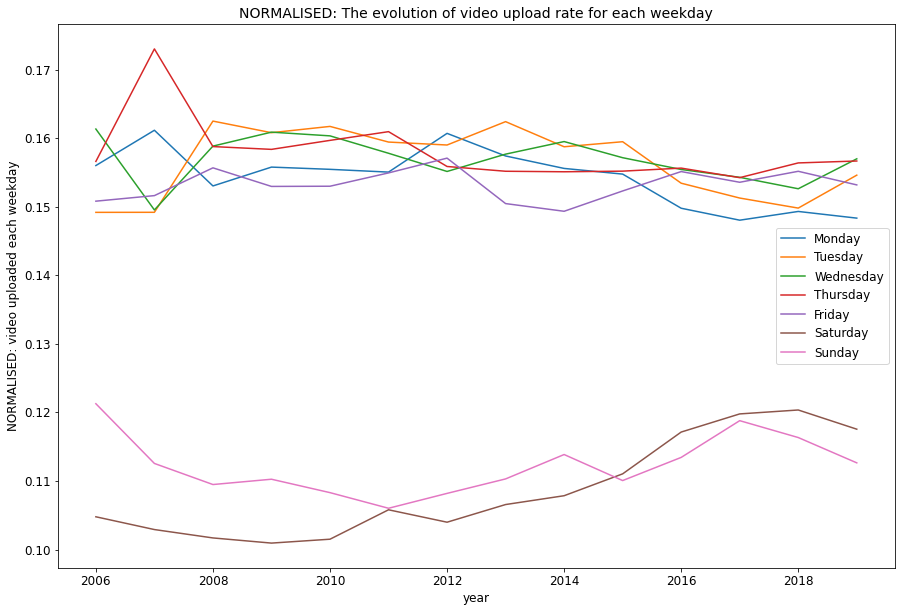

In [35]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()


In [ ]:
# it seems that weekdays are prefered day to upload videos compared to weekends. However, which day of the week doesn't seem to matter too much.


---

# How long does it take to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [20]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [21]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [22]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


MemoryError: Unable to allocate 576. MiB for an array with shape (4, 18872499) and data type float64

In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


In [ ]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [23]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M


NameError: name 'data' is not defined

In [ ]:
print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


---

# Number of views, likes, dislikes per categorie and date uploaded

For this task we analyze and plot the data to get some intuition, and use logistic regression to 'predict' the number of views per category and date. 

In [37]:
video_metadatas.head()
video_metadatas.shape


(72924794, 10)

In [38]:
# I added this [:] to make a copy of the video_metadatas, so that the following operation wont affect the original video_metadatas
videos_with_cat = video_metadatas[:]
# here I tried to use the same expression as the replace you used below but it doesnt seem to work...
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)
# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)
videos_with_cat.shape


(72923272, 10)

In [39]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)


In [40]:
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [41]:
mean_views = video_metadatas_encoded.groupby(["year", "categories"]).apply(
    lambda x: pd.Series({"mean_view": x.view_count.mean()})
)


In [42]:
mean_views[:10]


mean_view
year categories                      
2005 Autos_Vehicles      7.358667e+03
     Comedy              2.261696e+06
     Education           1.159814e+04
     Entertainment       1.785133e+05
     Film_Animation      3.186667e+03
     Howto_Style         1.148443e+05
     Music               9.104648e+06
     News_Politics       7.239000e+03
     Pets_Animals        2.199727e+04
     Science_Technology  5.572000e+03

In [55]:
# see the top most viewed categories every year
largest_cat_every_year = (
    mean_views.groupby("year")["mean_view"].nlargest(2).droplevel(0)
)
largest_cat_every_year[:30]


year  categories    
2005  Music             9.104648e+06
      Comedy            2.261696e+06
2006  Music             1.007414e+06
      Education         7.095613e+05
2007  Comedy            6.295976e+05
      Music             6.209835e+05
2008  Music             5.972537e+05
      Comedy            4.863888e+05
2009  Music             1.847631e+06
      Comedy            6.313687e+05
2010  Music             5.108399e+05
      Comedy            4.098030e+05
2011  Music             4.568082e+05
      Comedy            3.680102e+05
2012  Comedy            3.401340e+05
      Music             3.286517e+05
2013  Comedy            3.600942e+05
      Music             3.541127e+05
2014  Music             3.448955e+05
      Comedy            3.220815e+05
2015  Music             3.371702e+05
      Comedy            3.070568e+05
2016  Music             2.982474e+05
      Comedy            2.815195e+05
2017  Comedy            2.920754e+05
      Music             2.844821e+05
2018  Comedy     

In [44]:
# Alternatively, I suggest the following to determine which type of videos are more popular
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!


In [45]:
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None

video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None

video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None


In [46]:
videos_with_cat.loc[
    videos_with_cat["categories"] == "Movies",
]


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,duration_min,yearNumber,weekNumber
33264189,Movies,2016-01-14,229,2146.0,202.0,170642.0,UCwaNuezahYT3BOjfXsne2mg,3.816667,2016,3
60439051,Movies,2014-10-27,273,3608.0,107.0,189267.0,UC6xOVUMstTf08rUgOFbyPEA,4.550000,2014,0
63357486,Movies,2015-10-20,190,877.0,19.0,32070.0,UC4zJAMaYN592qQhMR2OfX_Q,3.166667,2015,1
63357602,Movies,2013-10-14,227,576.0,38.0,36410.0,UC4zJAMaYN592qQhMR2OfX_Q,3.783333,2013,0
63357641,Movies,2013-02-24,110,2836.0,92.0,284059.0,UC4zJAMaYN592qQhMR2OfX_Q,1.833333,2013,6


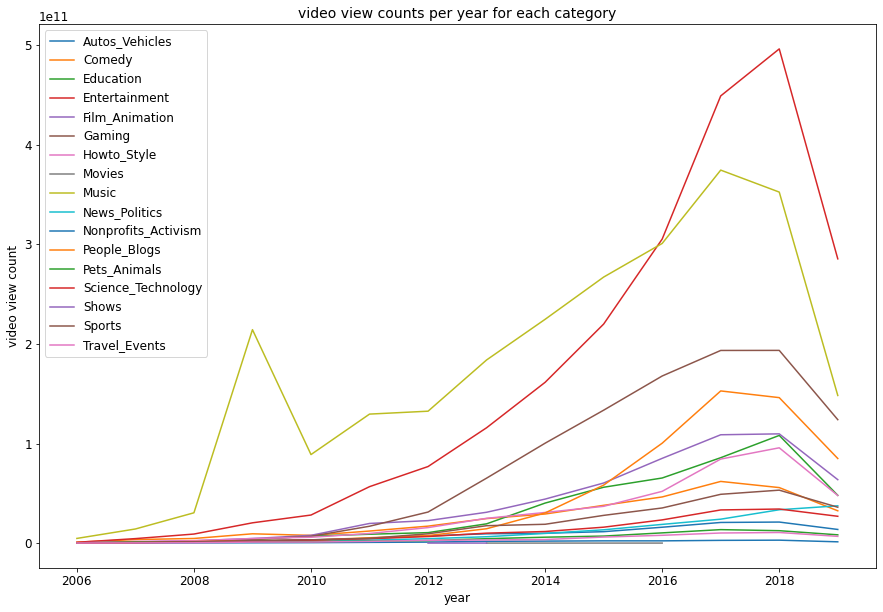

In [47]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()


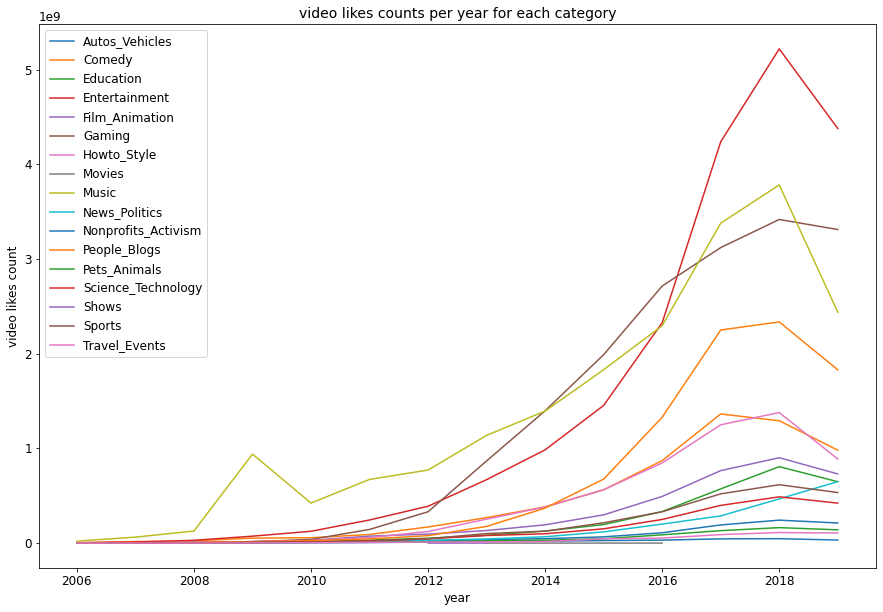

In [48]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:],
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video likes count")
plt.title("video likes counts per year for each category")
plt.show()


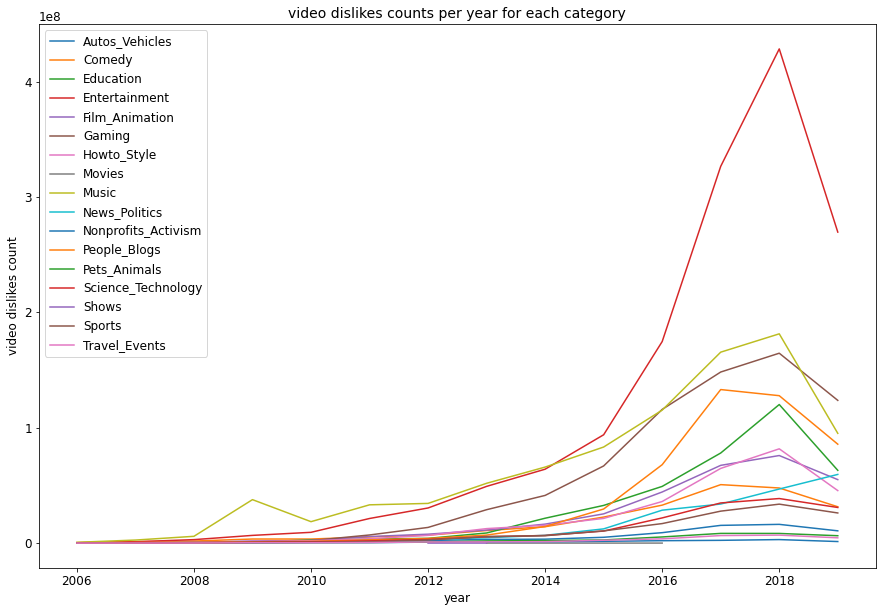

In [49]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:],
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


As previous graphs are distorted, we normalize by....

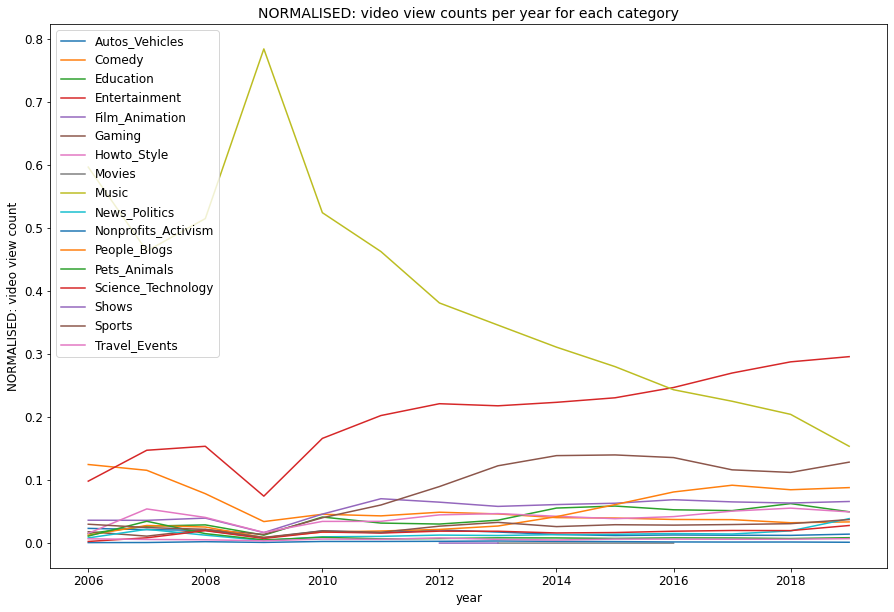

In [56]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases


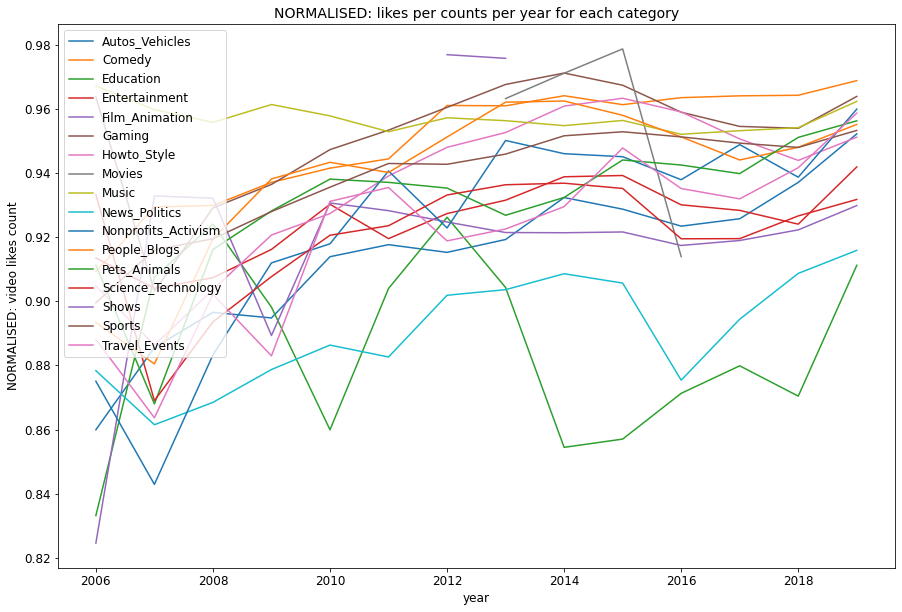

In [57]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_like_count_by_year.loc[
                i,
            ][2:]
            + video_dislike_count_by_year.loc[
                i,
            ][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: likes per counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved


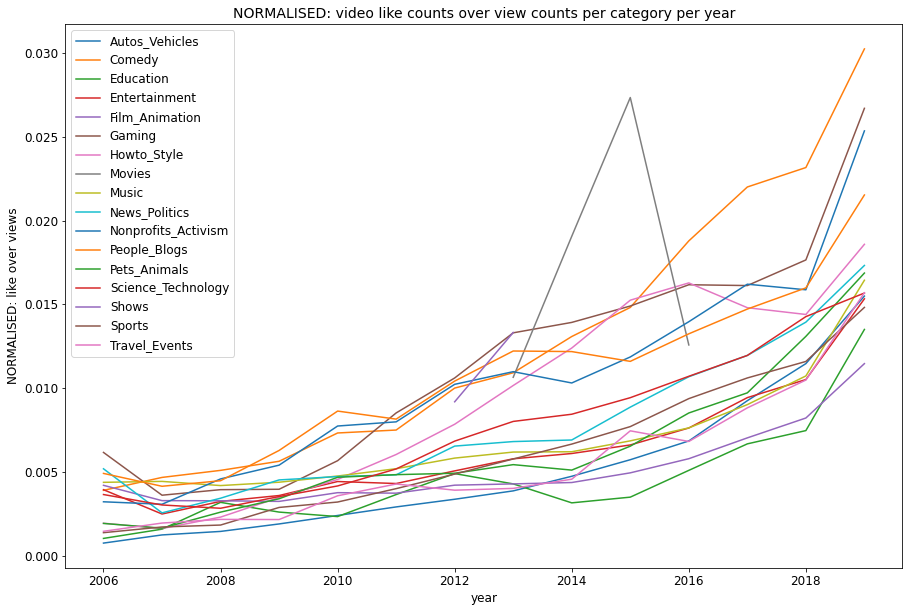

In [60]:
## 3. like count versus view count - normalise wrt. total like counts over view counts for each category for each year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_view_count_by_year.loc[
                i][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: like over views")
plt.title("NORMALISED: video like counts over view counts per category per year")
plt.show()



In [94]:
# join channel data and metadata by channel ID
metadata_channels = pd.merge(video_metadatas, df_channels[['channel', 'subscribers_cc']],
                 left_on=['channel_id'],right_on=['channel'], how='right')



In [101]:
metadata_channels["view_subscriber_ratio"]= metadata_channels["view_count"]/metadata_channels["subscribers_cc"]

In [106]:
metadata_channels_select = metadata_channels[metadata_channels["categories"].isin(["Comedy","Education","Sports"])]
len(metadata_channels_select)

9322479

In [114]:
metdadata_channels_by_year= (
    metadata_channels_select.dropna(axis=0).groupby(["yearNumber","categories"], as_index=False)["view_subscriber_ratio"].agg(["sum","count"])
)

In [118]:
metdadata_channels_by_year = metdadata_channels_by_year.reset_index()
metdadata_channels_by_year["mean"] = metdadata_channels_by_year["sum"]/metdadata_channels_by_year["count"]

In [123]:
metdadata_channels_by_year.sort_values(["categories", "yearNumber"])

,yearNumber,categories,sum,count,mean
0,2005,Comedy,23.904951,29,0.824309
3,2006,Comedy,9604.483721,1781,5.392748
6,2007,Comedy,17379.333762,5673,3.063517
9,2008,Comedy,16131.285602,9495,1.698924
12,2009,Comedy,33633.820873,14681,2.290976
15,2010,Comedy,32518.344727,18765,1.732925
18,2011,Comedy,44708.172473,32617,1.370702
21,2012,Comedy,47378.602264,49901,0.949452
24,2013,Comedy,57326.242138,67020,0.855360
27,2014,Comedy,73330.636519,89850,0.816145


<AxesSubplot:xlabel='yearNumber', ylabel='mean'>

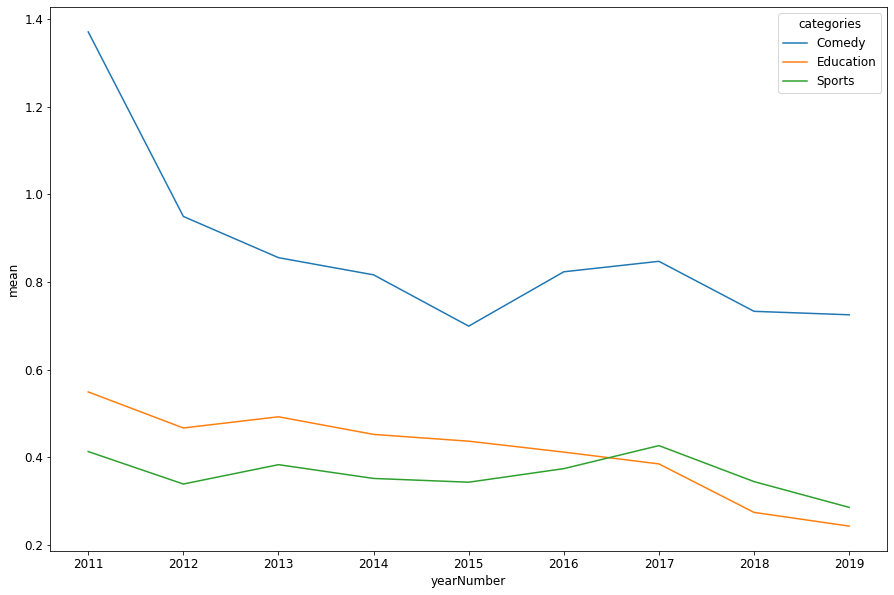

In [125]:
import seaborn as sns

sns.lineplot(data=metdadata_channels_by_year[metdadata_channels_by_year["yearNumber"]>2010],
                                             x ="yearNumber", y="mean", hue="categories")

# Use Least Square to predict the number of views given the category and the date

In [ ]:
def choose_video_metadata_year(year):
    return video_metadatas[video_metadatas["year"] == year]


In [ ]:
video_metadatas["year"] = video_metadatas["upload_date"].dt.year


In [ ]:
video_metadatas.head()


In [ ]:
video_metadatas.columns


In [ ]:
video_metadatas_2005 = choose_video_metadata_year(2005)
video_metadatas_2005.drop(["upload_date", "channel_id"], axis=1, inplace=True)
video_metadatas_2005.head()


In [ ]:
model = smf.ols(
    formula="view_count ~ duration + C(categories)", data=video_metadatas_2005
)

res = model.fit()
print(res.summary())

# print(res.predict([120, 'Music']))


---

# Implement the # of views divided by the # of subs 

In [ ]:
# use the time series dataframe to implement this, it would be easier. 
df_time_series['year'] = df_time_series.datetime.dt.year
df_time_series.sample(4)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,views_over_subs
1255565,UCj56GATzRKv5aiyqq5pI2FA,People & Blogs,2016-08-08 00:00:00,1.242718e+07,896341.750,14049.500000,76.50,0,0,0,2016,11716.885621
8031961,UCb1lfdYKtYUlITz5sRZrjXg,Gaming,2019-06-24 01:00:00,1.356022e+07,0.000,188803.864583,1027.25,93,0,0,2019,0.000000
9345305,UCeJfZqIcyy1z3wySHq4iDDg,Entertainment,2016-08-08 00:00:00,3.965854e+05,7550.375,7220.750000,162.75,33,1,2,2016,46.392473
15564767,UCH1dpzjCEiGAt8CXkryhkZg,News & Politics,2019-07-15 00:00:00,3.807654e+07,93307.375,193327.500000,1389.50,738,8,19,2019,67.151763


In [ ]:
# penalize the big channel (many subs) by dividing the number of delta views by nb of total subscribers
df_time_series['views_over_subs'] = df_time_series.delta_views / df_time_series.subs
df_time_series.sample(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,views_over_subs
18824863,UC1mfRlR2A51J6CdjnKSOMcA,Comedy,2019-06-10 00:00:00,8.787830e+05,0.000000,24298.076923,0.000000,3,1,1,2019,0.000000
7518558,UCZvMYyu8lODcgfU-3xuCm6g,Gaming,2017-07-17 00:00:00,6.680287e+05,22402.333333,974.000000,35.000000,29,1,1,2017,23.000342
11954571,UCjaexUe5ZKwG6qead0lh-3g,Gaming,2018-06-04 01:00:00,2.617512e+06,57120.515625,49836.979167,585.244792,260,10,17,2018,1.146147
15799056,UCWf3wmxbUr5TGmCjHaXV4bQ,Gaming,2018-03-26 00:00:00,2.980532e+07,21517.351085,139047.732984,0.000000,332,0,1,2018,0.154748
18539746,UC0jxua6gd8cCQPKuldKOqqA,Music,2017-11-13 00:00:00,3.191754e+06,11781.500000,19603.750000,73.250000,435,2,3,2017,0.600982


In [ ]:
df_time_series[df_time_series.delta_views == 0].category.value_counts()

Entertainment            94260
Music                    85789
Gaming                   78886
People & Blogs           57165
Howto & Style            34227
Education                26488
Film and Animation       25814
Sports                   18834
Science & Technology     16352
Comedy                   15967
Autos & Vehicles         11119
News & Politics           9185
Travel & Events           5851
Pets & Animals            3835
Nonprofits & Activism     3567
Name: category, dtype: int64

In [ ]:
views_over_subs_per_year = (
    df_time_series.groupby(["category", "year"]).sum()
)
views_over_subs_per_year.head(10)

views   delta_views          subs    delta_subs  \
category         year                                                           
Autos & Vehicles 2015  2.996063e+08  5.147088e+06  4.757975e+05  6.147216e+03   
                 2016  6.912082e+11  5.204093e+09  1.604181e+09  1.262457e+07   
                 2017  2.800755e+12  2.259653e+10  7.656504e+09  6.611185e+07   
                 2018  4.059051e+12  3.080456e+10  1.228774e+10  1.149792e+08   
                 2019  4.010183e+12  2.744996e+10  1.340572e+10  9.883009e+07   
Comedy           2015  5.407901e+07  1.893648e+06  1.312303e+05  3.011729e+03   
                 2016  1.598243e+12  1.084603e+10  7.149362e+09  4.491931e+07   
                 2017  8.626162e+12  6.309105e+10  3.919384e+10  2.553993e+08   
                 2018  1.181219e+13  7.909585e+10  5.546370e+10  3.971761e+08   
                 2019  1.137787e+13  7.406437e+10  5.549048e+10  3.177507e+08   

                         videos  delta_videos  activity  views_over_subs  
category         year                                                     
Autos & Vehicles 2015      6310            31        65     1.381529e+03  
                 2016  29588894        129125    298930     7.464736e+05  
                 2017  72898692        329971    731018     1.954820e+06  
                 2018  90862518        363152    802144     1.210751e+06  
                 2019  80806310        290835    637449     4.117277e+05  
Comedy           2015      8177            34        83     6.074186e+02  
                 2016   8702971         49189    115875     5.124242e+05  
                 2017  28914021        178175    398725     1.252861e+06  
                 2018  38985639        193894    431397     7.384284e+05  
                 2019  35910143        153924    340402     4.351579e+05

In [ ]:
views_over_subs_per_year = views_over_subs_per_year.views_over_subs.unstack().reset_index()
views_over_subs_per_year.columns.name = None
views_over_subs_per_year

,category,2015,2016,2017,2018,2019
0,Autos & Vehicles,1381.529223,7.464736e+05,1.954820e+06,1.210751e+06,4.117277e+05
1,Comedy,607.418633,5.124242e+05,1.252861e+06,7.384284e+05,4.351579e+05
2,Education,2400.654079,1.831725e+06,2.403674e+06,7.240738e+06,6.236384e+05
3,Entertainment,19505.687509,6.136368e+06,3.750412e+07,1.230867e+07,3.231113e+06
4,Film and Animation,1067.267887,1.055584e+06,9.495312e+06,2.550718e+06,9.445939e+05
5,Gaming,5281.516019,2.640167e+06,9.060244e+06,7.330692e+06,2.207970e+06
6,Howto & Style,2709.301731,9.129834e+05,3.158939e+06,3.022023e+06,6.483650e+05
7,Music,2512.123685,4.298860e+06,8.706082e+06,8.025322e+06,3.682171e+06
8,News & Politics,2018.770165,4.166610e+05,1.162869e+06,7.047117e+05,8.007037e+05
9,Nonprofits & Activism,15.785679,8.921717e+04,1.717722e+05,1.290141e+05,7.548645e+04


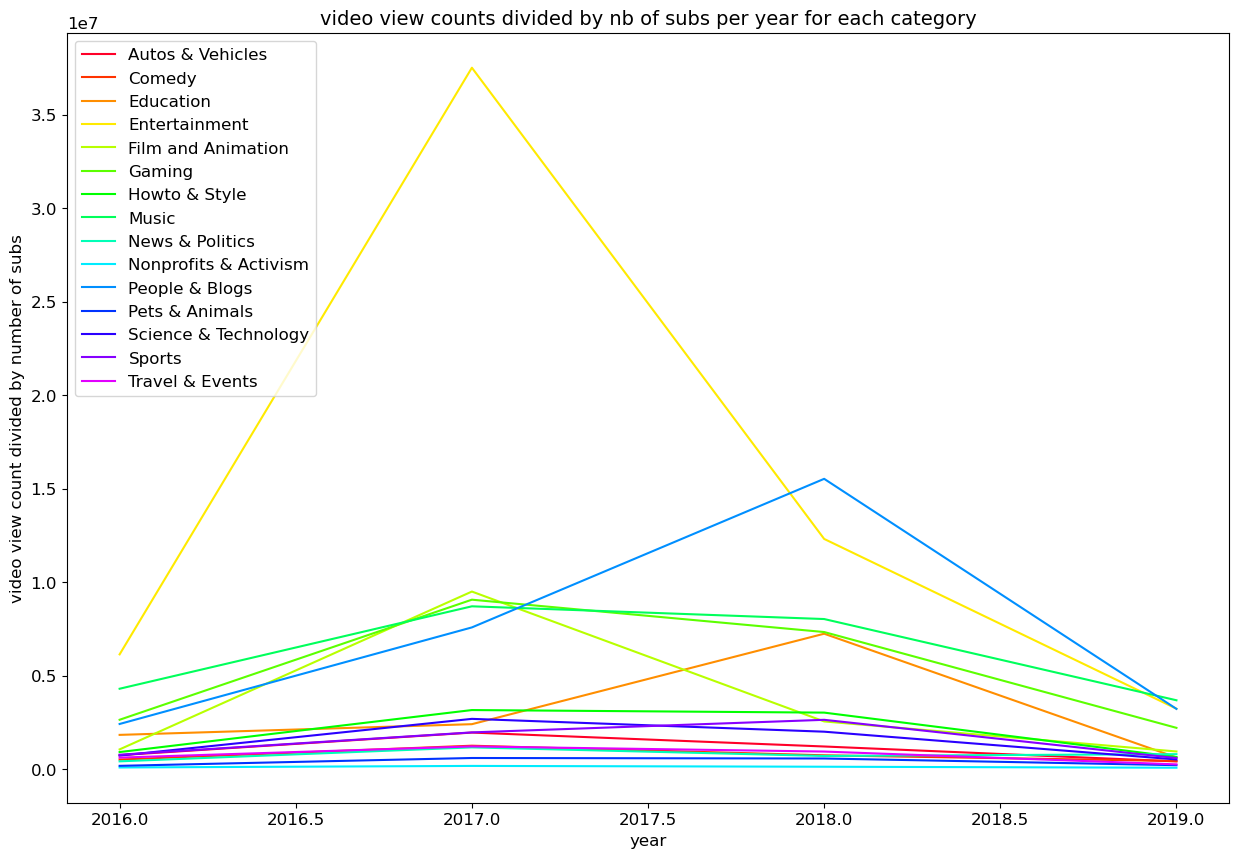

In [ ]:
NUM_COLORS = 15
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(views_over_subs_per_year.shape[0]):
    plt.plot(
        views_over_subs_per_year.loc[
            i,
        ][2:],
        label=views_over_subs_per_year.loc[i,][
            0:1
        ][0],
    )
    
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count divided by number of subs")
plt.title("video view counts divided by nb of subs per year for each category")
plt.show()

---

In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)
